Student: Denny Boechat.

Course: Advanced Big Data and Data Mining (MSCS-634-B01).

Project Deliverable 2: Regression Modeling and Performance Evaluation

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('dataset/general_dentistry_approintments.csv')

1- Present details of original dataset

In [20]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   project_name                      413 non-null    object 
 1   patient_full_name                 413 non-null    object 
 2   patient_date_of_birth             413 non-null    object 
 3   gender                            413 non-null    object 
 4   general_appointment_date          379 non-null    object 
 5   general_prescribed_medications    79 non-null     object 
 6   patient_height                    346 non-null    float64
 7   patient_weight                    363 non-null    float64
 8   patient_temperature               413 non-null    float64
 9   patient_blood_glucose             237 non-null    float64
 10  patient_pulse                     361 non-null    float64
 11  patient_oxygen_saturation         360 non-null    float64
 12  patient_

,patient_height,patient_weight,patient_temperature,patient_blood_glucose,patient_pulse,patient_oxygen_saturation,patient_blood_pressure_diastolic
count,346.000000,363.000000,413.000000,237.000000,361.000000,360.000000,300.000000
mean,154.533815,70.108457,36.596852,118.240506,85.235457,97.655556,81.760000
std,30.329594,36.541003,0.292154,52.829246,17.101250,1.698179,11.737474
min,60.000000,6.400000,35.500000,40.000000,45.000000,77.000000,48.000000
25%,138.125000,33.100000,36.400000,93.000000,74.000000,97.000000,74.000000
50%,167.000000,79.800000,36.600000,104.000000,83.000000,98.000000,82.000000
75%,176.000000,97.850000,36.700000,124.000000,96.000000,99.000000,90.000000
max,194.000000,168.000000,37.700000,377.000000,152.000000,100.000000,122.000000


2- Perform feature engineering to create or improve features that enhance model performance.

In [21]:
# Convert date columns to datetime
df['patient_date_of_birth'] = pd.to_datetime(df['patient_date_of_birth'], errors='coerce')
df['general_appointment_date'] = pd.to_datetime(df['general_appointment_date'], errors='coerce')
df['dental_appointment_date'] = pd.to_datetime(df['dental_appointment_date'], errors='coerce')

# Feature 1: Age
current_date = pd.to_datetime("today")
df['patient_age'] = df['patient_date_of_birth'].apply(lambda dob: (current_date - dob).days // 365 if pd.notnull(dob) else None)

# Feature 2: BMI (Body Mass Index)
df['bmi'] = df.apply(
    lambda row: row['patient_weight'] / ((row['patient_height'] / 100) ** 2)
    if pd.notnull(row['patient_weight']) and pd.notnull(row['patient_height']) and row['patient_height'] > 0
    else None,
    axis=1
)

# Feature 3: Appointment Flags
df['has_general_appointment'] = df['general_appointment_date'].notnull().astype(int)
df['has_dental_appointment'] = df['dental_appointment_date'].notnull().astype(int)

# Feature 4: Medication Flags
df['has_general_medications'] = df['general_prescribed_medications'].notnull().astype(int)
df['has_dental_medications'] = df['dental_prescribed_medications'].notnull().astype(int)

# Feature 5: Treated Teeth Count
df['treated_teeth_count'] = df['treated_teeth'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)

# Feature 6: Note Lengths
df['general_note_length'] = df['general_notes'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
df['dental_note_length'] = df['dental_notes'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

# Feature 7: Abnormal Vital Signs (basic heuristics)
df['abnormal_temperature'] = df['patient_temperature'].apply(lambda x: 1 if x < 36 or x > 37.5 else 0)
df['abnormal_blood_glucose'] = df['patient_blood_glucose'].apply(lambda x: 1 if x < 70 or x > 140 else 0 if pd.notnull(x) else 0)
df['abnormal_pulse'] = df['patient_pulse'].apply(lambda x: 1 if x < 60 or x > 100 else 0 if pd.notnull(x) else 0)
df['abnormal_oxygen_saturation'] = df['patient_oxygen_saturation'].apply(lambda x: 1 if x < 95 else 0 if pd.notnull(x) else 0)

# Display the first few rows of the enhanced DataFrame
df.head()

,project_name,patient_full_name,patient_date_of_birth,gender,general_appointment_date,general_prescribed_medications,patient_height,patient_weight,patient_temperature,patient_blood_glucose,...,has_dental_appointment,has_general_medications,has_dental_medications,treated_teeth_count,general_note_length,dental_note_length,abnormal_temperature,abnormal_blood_glucose,abnormal_pulse,abnormal_oxygen_saturation
0,Ambovombe,Aidah,1983-03-05,female,NaT,NaN,NaN,NaN,36.6,NaN,...,1,0,0,3,0,4,0,0,0,0
1,Ambovombe,Braim,2002-03-29,male,NaT,NaN,NaN,NaN,36.6,NaN,...,1,0,0,2,0,10,0,0,0,0
2,Ambovombe,Datsizy,2007-11-09,male,NaT,NaN,NaN,NaN,36.6,NaN,...,1,0,0,2,0,74,0,0,0,0
3,Ambovombe,Edvine,1966-05-09,female,NaT,NaN,NaN,NaN,36.6,NaN,...,1,0,0,2,0,0,0,0,0,0
4,Ambovombe,Homendoe nestiline,2005-06-06,female,NaT,NaN,NaN,NaN,36.6,NaN,...,1,0,0,1,0,0,0,0,0,0


3- Linear Regression

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define target and features
target = 'patient_blood_glucose'

features = [
    'patient_age', 'bmi', 'has_general_appointment', 'has_dental_appointment',
    'has_general_medications', 'has_dental_medications', 'treated_teeth_count',
    'general_note_length', 'dental_note_length',
    'abnormal_temperature', 'abnormal_pulse', 'abnormal_oxygen_saturation'
]

# Drop rows with missing target or feature values
model_data = df[features + [target]].dropna()

# Split data into train/test sets
X = model_data[features]
y = model_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Optional: Show model coefficients
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
})
print(coef_df)


Mean Squared Error: 2794.3686221316434
R-squared Score: 0.11552266610923478
                       Feature   Coefficient
0                  patient_age  1.290642e+00
1                          bmi -3.618149e-01
2      has_general_appointment  8.226753e-14
3       has_dental_appointment -2.473352e+00
4      has_general_medications  1.771280e+00
5       has_dental_medications  2.028130e+01
6          treated_teeth_count -7.551243e+00
7          general_note_length  3.302941e-02
8           dental_note_length -7.130947e-02
9         abnormal_temperature -3.833614e+01
10              abnormal_pulse  1.308554e+01
11  abnormal_oxygen_saturation  6.104356e+01


4- Multiple Regression

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Define target and features for Multiple Linear Regression
target = 'patient_blood_glucose'
features = [
    'patient_age', 'bmi',
    'has_general_appointment', 'has_dental_appointment',
    'has_general_medications', 'has_dental_medications',
    'treated_teeth_count',
    'general_note_length', 'dental_note_length',
    'abnormal_temperature', 'abnormal_pulse', 'abnormal_oxygen_saturation'
]

# Prepare the data
model_data = df[features + [target]].dropna()

X = model_data[features]
y = model_data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and fit the model
multi_reg_model = LinearRegression()
multi_reg_model.fit(X_train, y_train)

# Predictions
y_pred = multi_reg_model.predict(X_test)

# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output results
print("Multiple Linear Regression Results")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

# Coefficients
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': multi_reg_model.coef_
})
print("\nModel Coefficients:")
print(coefficients)


Multiple Linear Regression Results
Mean Squared Error (MSE): 2794.3686221316434
R-squared (R²): 0.11552266610923478

Model Coefficients:
                       Feature   Coefficient
0                  patient_age  1.290642e+00
1                          bmi -3.618149e-01
2      has_general_appointment  8.226753e-14
3       has_dental_appointment -2.473352e+00
4      has_general_medications  1.771280e+00
5       has_dental_medications  2.028130e+01
6          treated_teeth_count -7.551243e+00
7          general_note_length  3.302941e-02
8           dental_note_length -7.130947e-02
9         abnormal_temperature -3.833614e+01
10              abnormal_pulse  1.308554e+01
11  abnormal_oxygen_saturation  6.104356e+01


5- Lasso

In [24]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Define the target and features
target = 'patient_blood_glucose'
features = [
    'patient_age', 'bmi',
    'has_general_appointment', 'has_dental_appointment',
    'has_general_medications', 'has_dental_medications',
    'treated_teeth_count',
    'general_note_length', 'dental_note_length',
    'abnormal_temperature', 'abnormal_pulse', 'abnormal_oxygen_saturation'
]

# Prepare the data
model_data = df[features + [target]].dropna()
X = model_data[features]
y = model_data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and fit Lasso Regression model
lasso_model = Lasso(alpha=0.1)  # You can tune alpha as needed
lasso_model.fit(X_train, y_train)

# Predictions
y_pred = lasso_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Lasso Regression Results")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

# Coefficients
lasso_coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': lasso_model.coef_
})
print("\nLasso Model Coefficients:")
print(lasso_coefficients)


Lasso Regression Results
Mean Squared Error (MSE): 2792.494366905456
R-squared (R²): 0.11611590790717063

Lasso Model Coefficients:
                       Feature  Coefficient
0                  patient_age     1.276907
1                          bmi    -0.356112
2      has_general_appointment     0.000000
3       has_dental_appointment    -1.538781
4      has_general_medications     1.699621
5       has_dental_medications    14.960545
6          treated_teeth_count    -5.692601
7          general_note_length     0.032986
8           dental_note_length    -0.063794
9         abnormal_temperature   -29.511931
10              abnormal_pulse    11.321136
11  abnormal_oxygen_saturation    55.214903


6- Ridge

In [25]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Define target and features
target = 'patient_blood_glucose'
features = [
    'patient_age', 'bmi',
    'has_general_appointment', 'has_dental_appointment',
    'has_general_medications', 'has_dental_medications',
    'treated_teeth_count',
    'general_note_length', 'dental_note_length',
    'abnormal_temperature', 'abnormal_pulse', 'abnormal_oxygen_saturation'
]

# Prepare data
model_data = df[features + [target]].dropna()
X = model_data[features]
y = model_data[target]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and fit Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # You can tune alpha as needed
ridge_model.fit(X_train, y_train)

# Make predictions
y_pred = ridge_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Ridge Regression Results")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

# Show coefficients
ridge_coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': ridge_model.coef_
})
print("\nRidge Model Coefficients:")
print(ridge_coefficients)


Ridge Regression Results
Mean Squared Error (MSE): 2790.6687456583077
R-squared (R²): 0.11669375601231446

Ridge Model Coefficients:
                       Feature  Coefficient
0                  patient_age     1.271165
1                          bmi    -0.378487
2      has_general_appointment     0.000000
3       has_dental_appointment    -2.427678
4      has_general_medications     2.326107
5       has_dental_medications    16.095905
6          treated_teeth_count    -5.997953
7          general_note_length     0.032673
8           dental_note_length    -0.063489
9         abnormal_temperature   -25.508481
10              abnormal_pulse    11.678059
11  abnormal_oxygen_saturation    45.465804


7- Evaluate models using R-squared

In [26]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Define the target and features
target = 'patient_blood_glucose'
features = [
    'patient_age', 'bmi',
    'has_general_appointment', 'has_dental_appointment',
    'has_general_medications', 'has_dental_medications',
    'treated_teeth_count',
    'general_note_length', 'dental_note_length',
    'abnormal_temperature', 'abnormal_pulse', 'abnormal_oxygen_saturation'
]

# Prepare the dataset
model_data = df[features + [target]].dropna()
X = model_data[features]
y = model_data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Ridge Regression': Ridge(alpha=1.0)
}

# Train, predict, and evaluate each model
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'R-squared': r2, 'MSE': mse})

# Create a comparison DataFrame
evaluation_df = pd.DataFrame(results)

# Display results
print("Model Evaluation Summary:")
print(evaluation_df)


Model Evaluation Summary:
               Model  R-squared          MSE
0  Linear Regression   0.115523  2794.368622
1   Lasso Regression   0.116116  2792.494367
2   Ridge Regression   0.116694  2790.668746


8- Evaluation using Mean Squared Error (MSE)

In [27]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

# Define target and features
target = 'patient_blood_glucose'
features = [
    'patient_age', 'bmi',
    'has_general_appointment', 'has_dental_appointment',
    'has_general_medications', 'has_dental_medications',
    'treated_teeth_count',
    'general_note_length', 'dental_note_length',
    'abnormal_temperature', 'abnormal_pulse', 'abnormal_oxygen_saturation'
]

# Prepare data
model_data = df[features + [target]].dropna()
X = model_data[features]
y = model_data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Ridge Regression': Ridge(alpha=1.0)
}

# Evaluate using MSE
mse_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_results[name] = mse

# Print MSE results
print("Mean Squared Error (MSE) for each model:")
for model_name, mse in mse_results.items():
    print(f"{model_name}: {mse:.2f}")


Mean Squared Error (MSE) for each model:
Linear Regression: 2794.37
Lasso Regression: 2792.49
Ridge Regression: 2790.67


9- Cross-validation to assess model ability to generalize to unseen data

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import numpy as np
import pandas as pd

# Define target and features
target = 'patient_blood_glucose'
features = [
    'patient_age', 'bmi',
    'has_general_appointment', 'has_dental_appointment',
    'has_general_medications', 'has_dental_medications',
    'treated_teeth_count',
    'general_note_length', 'dental_note_length',
    'abnormal_temperature', 'abnormal_pulse', 'abnormal_oxygen_saturation'
]

# Prepare dataset
model_data = df[features + [target]].dropna()
X = model_data[features]
y = model_data[target]

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Ridge Regression': Ridge(alpha=1.0)
}

# Perform cross-validation
cv_results = []
for name, model in models.items():
    neg_mse_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    mean_mse = -np.mean(neg_mse_scores)
    std_mse = np.std(neg_mse_scores)
    cv_results.append({'Model': name, 'Mean MSE': mean_mse, 'Std MSE': std_mse})

# Show results
cv_df = pd.DataFrame(cv_results)
print("Cross-Validation Results (5-Fold):")
print(cv_df)


Cross-Validation Results (5-Fold):
               Model     Mean MSE      Std MSE
0  Linear Regression  2539.665590  1463.928930
1   Lasso Regression  2534.042812  1446.850807
2   Ridge Regression  2540.320519  1450.252587


10- Visualize model performance

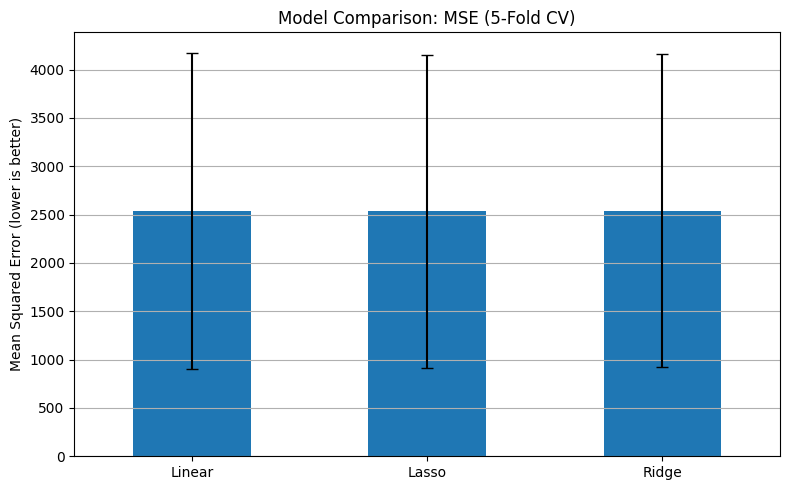

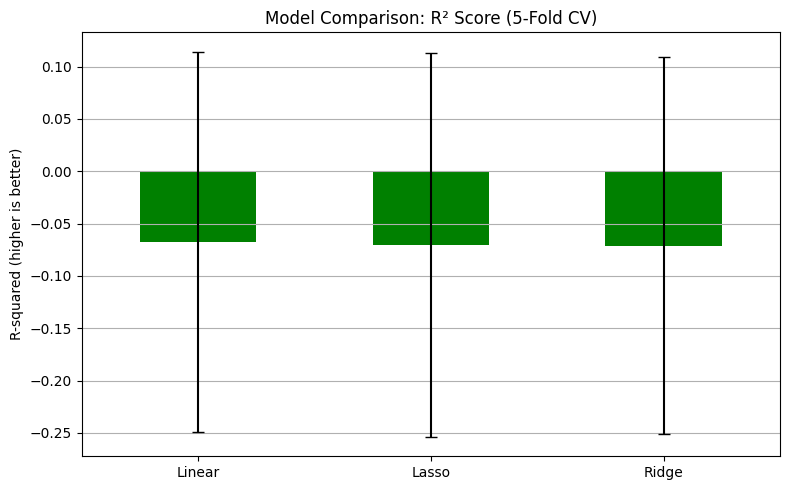

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define target and features
target = 'patient_blood_glucose'
features = [
    'patient_age', 'bmi',
    'has_general_appointment', 'has_dental_appointment',
    'has_general_medications', 'has_dental_medications',
    'treated_teeth_count',
    'general_note_length', 'dental_note_length',
    'abnormal_temperature', 'abnormal_pulse', 'abnormal_oxygen_saturation'
]

# Prepare dataset
model_data = df[features + [target]].dropna()
X = model_data[features]
y = model_data[target]

# Define models
models = {
    'Linear': LinearRegression(),
    'Lasso': Lasso(alpha=0.1),
    'Ridge': Ridge(alpha=1.0)
}

# Store scores
mse_scores = {}
r2_scores = {}

# Evaluate each model using cross-validation
for name, model in models.items():
    mse = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    r2 = cross_val_score(model, X, y, scoring='r2', cv=5)
    mse_scores[name] = mse
    r2_scores[name] = r2

# Create summary DataFrames
mse_df = pd.DataFrame({model: scores for model, scores in mse_scores.items()})
r2_df = pd.DataFrame({model: scores for model, scores in r2_scores.items()})

# Plot MSE
plt.figure(figsize=(8, 5))
mse_df.mean().plot(kind='bar', yerr=mse_df.std(), capsize=4)
plt.ylabel("Mean Squared Error (lower is better)")
plt.title("Model Comparison: MSE (5-Fold CV)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot R-squared
plt.figure(figsize=(8, 5))
r2_df.mean().plot(kind='bar', yerr=r2_df.std(), capsize=4, color='green')
plt.ylabel("R-squared (higher is better)")
plt.title("Model Comparison: R² Score (5-Fold CV)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
